# Transforer

챗봇을 만들기 위해 여러가지 방법론이 있는데 가장 대중적인 방법은 Seq2Seq Model, Transformer Model 등을 이용하는 방법입니다. 2017년에 논문 "Attention Is All You Need"에서 제시한 트랜스포머는 자연어 처리 분야에서 필수적으로 알아야 할 모델입니다. 트랜스포머는 언어 이해에 적합한 self-attention 메커니즘을 사용합니다. 트랜스포머에는 인코더-디코더 아키텍처가 있습니다. 이들은 피드포워드 및 attention 레이어를 포함하는 모듈로 구성됩니다. BERT나 GPT 같은 최신 모델이 모두 트랜스포머에 기반하고 있습니다. (BERT는 트랜스포머의 인코더 부분을 사용한 것이고 GPT는 디코더 부분을 사용한 것입니다)

Transformer 에 관한 이론적인 내용들은 여러 싸이트에 많은 내용이 있습니다. 이론적인 내용은 다음 싸이트를 참고 하시기 바랍니다.

딥 러닝을 이용한 자연어 처리 입문 17. 트랜스포머(Transformer) https://wikidocs.net/31379

트랜스포머는 인코더 블록과 디코더 블록으로 구성된 인코더-디코더 신경망입니다. 모든 구성요소를 구현하려면 꽤 복잡합니다. 다행히도 파이토치에는 nn.Transformer로 트랜스포머가 구현되어 있습니다. nn.Transformerhttps://pytorch.org/docs/stable/generated/torch.nn.Transformer.html#transformer

torch.nn.Transformer(d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1, activation=, custom_encoder=None, custom_decoder=None, layer_norm_eps=1e-05, batch_first=False, norm_first=False, device=None, dtype=None)

Examples::



In [1]:
transformer_model = nn.Transformer(nhead=16, num_encoder_layers=12)
src = torch.rand((10, 32, 512))
tgt = torch.rand((20, 32, 512))
out = transformer_model(src, tgt)


NameError: ignored

왼쪽 블록은 인코더이고 오른쪽 블록은 디코더입니다. nn.Transformer는 전체 구조에서 가운데 부분 즉 멀티헤드 어텐션과 피드 포워드 등 을 처리합니다. Linear, Positional Encoding, Embedding 등은 따로 만들어줘야 합니다.

먼저 시작하려면 몇가지 라이브러리들을 import 해야 합니다. 저는 필요 없는 것이라고 해도 다음 사항들은 무조건 import 하고 시작하는 편 입니다.



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import math
import numpy as np
import pandas as pd
import random
import re

from torch.utils.data import DataLoader, Dataset


## 기본 transformer 구조
트랜스포머 모듈은 "Attention is all you need" 모델에서 사용한 하이퍼파라미터와 함께 제공됩니다. 먼저 간단한 PyTorch의 nn.Module 모델을 만드는 것으로 시작하겠습니다. 모델이 학습하는데 불필요하게 오래 걸리지 않도록 기본 매개변수 중 일부만 변경할 것입니다. 이 매개변수를 클래스의 일부로 만들었습니다.

class Transformer(nn.Module):


In [3]:
class Transformer(nn.Module):
    def __init__(self, num_tokens, dim_model, num_heads, num_encoder_layers, num_decoder_layers, dropout_p, ):
        super().__init__()

        # Layers
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )

    def forward(self):
        pass


트랜스포머 모델의 주요 파라메터는 다음과 같습니다.

* d_model - 트랜스포머의 인코더와 디코더에서의 정해진 입력과 출력의 크기를 의미합니다. (default=512)
* num_encoder_layers - 트랜스포머 모델에서 인코더가 총 몇 층으로 구성되었는지를 의미합니다. (default=6)
* num_decoder_layers - 트랜스포머 모델에서 디코더가 총 몇 층으로 구성되었는지를 의미합니다. (default=6)
* nhead – 멀티헤드 어텐션 모델의 헤드 수, 어텐션을 사용할 때 여러 개로 분할해서 병렬로 어텐션을 수행하고 결과값을 다시 하나로 합치는 방식에서 병렬의 수 (default=8)
* dim_feedforward – feedforward network model 의 차원, 피드 포워드 신경망의 은닉층의 크기(default=2048).
## Positional encoding
트랜스포머는 입력 시퀀스의 순서에 신경 쓰지 않습니다. 물론 이것은 문제입니다. "나는 파인애플과 함께 피자를 먹었어"라고 말하는 것은 "파인애플이 피자와 함께 먹었어"라고 말하는 것과는 다릅니다. 트랜스포머 모델은 입력을 한번에 넣게 되어 있습니다. 따라서 순서정보를 주입할 필요가 있습니다. 이를 해결하는 솔루션이 포지셔널 인코딩입니다. 위치에 따라 요소에 "중요도를 부여"하는 방식입니다. 시퀀스의 다른 모든 요소와 관련하여 위치를 나타내는 각 요소에 대한 벡터를 생성한다는 것입니다.



토큰(token) 들의 시퀀스가 임베딩(embedding) 레이어로 전달되며, 이어서 포지셔널 인코딩(positional encoding) 레이어가 각 단어의 순서를 설명합니다.

PositionalEncoding 모듈은 시퀀스 안에서 토큰의 상대적인 또는 절대적인 위치에 대한 어떤 정보를 주입합니다. 여기에서, 우리는 다른 주파수(frequency) 의 sine 과 cosine 함수를 사용합니다. 어려워 보이지만 실제로는 포지셔널 인코딩 공식, dropout 및 잔차 연결 일 뿐입니다.



In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # 드롭 아웃
        self.dropout = nn.Dropout(dropout_p)

        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)

        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)

        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)

    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])


참고로 register_buffer 로 layer를 등록하면 optimizer가 업데이트하지 않고 하나의 layer로써 작용한다. 또한 state_dict()로 확인이 가능하고, GPU연산이 가능하다.

##모델 완성
nn.Transformer는 전체 구조에서 가운데 부분 즉 멀티헤드 어텐션과 피드 포워드 등 을 처리합니다. Linear, Positional Encoding, Embedding 등은 따로 만들어줘야 합니다. PositionalEncoding을 추가하기 전에 시퀀스의 각 요소가 (고정 정수 대신) 조작할 수 있는 벡터로 변환되도록 Embedding 레이어 가 필요합니다 . 또한 모델의 출력의 차원으로 변환할 수 있도록 최종 Linear 레이어가 필요합니다.

참고로 PyTorch의 permute()와 transpose()는 유사한 방식으로 작동합니다. transpose()는 딱 두 개의 차원을 맞교환할 수 있습니다. 그러나 permute()는 모든 차원들을 맞교환할 수 있습니다. 예를 들면,



In [ ]:
x = torch.rand(16, 32, 3)
y = x.tranpose(0, 2)  # [3, 32, 16]
z = x.permute(2, 1, 0)  # [3, 32, 16]


AttributeError: ignored

트랜스포머 클래스는 매우 복잡해 보이지만 각 부분이 하는 일을 이해한다면 실제로 구현하기에 매우 간단한 모델입니다. 몇가지 기능이 더 필요합니다.

## Target Masking
모델 구조를 자세히 보면 "Masked Multi-head Attention" 이라는 특수 블록이 있다는 것을 기억할 수 있습니다 .


마스킹이 무엇일까요? 텐서를 모델에 입력할 때 텐서에서 어떤 일이 일어나고 있는지 요약해 보겠습니다. 먼저 source tensor를 embed 하고 인코딩(positional encoding)합니다. 그런 다음 source tensor는 embedded 및 encoded (위치적으로) target vector를 사용 하여 디코더에 공급되는 이해할 수 없는 encoded tensor로 인코딩됩니다. 모델을 학습하기 위한 전체 target tensor를 확인 할 수 없습니다. 이에 대한 해결책이 masking tensor입니다. 이 텐서는 시퀀스의 모든 element에 대해 하나 이상의 element를 모델에 표시하기 때문에 특정 크기(sequence length x sequence length)로 구성됩니다. 이 행렬을 target vector에 추가하므로 행렬은 트랜스포머가 elements에 액세스할 수 있는 위치에는 0, 액세스할 수 없는 위치에는 마이너스 무한대로 구성됩니다. 즉 0으로 표시된 부분은 시퀀스의 element가 있는 부분입니다. 그림으로 설명하면 조금 더 도움이 될 것입니다.


##Padding Masking
텐서는 GPU에 저장할 수 있는 행렬이기 때문에 모든 차원이 같은 크기의 요소를 가져야 합니다. 그러나 자연어처리나 다른 크기의 이미지 처리와 같은 작업을 할 때는 동일한 차원이 아니게 됩니다. 따라서 우리는 " 특수 토큰 "을 사용하여 문장의 시작 위치(), 문장 끝 위치() 및 나머지 공간을 채우기 위한 토큰() 을 사용 해야 합니다. 이러한 토큰들은 정수 ID로 변환되어야 합니다(이 예에서는 각각 2, 3, 4임). 패딩 시퀀스는 다음과 같습니다.

패딩 마스크란 이러한 토큰 정보를 모델에 알리기 위해 패딩 토큰이 있는 위치에 True 값을 그렇지 않은 위치에 False 값을 넣은 이진 행렬을 사용합니다 .

우리가 이야기한 두 개의 마스킹 행렬을 생성하려면 트랜스포머 모델을 확장해야 합니다. NumPy를 조금 알고 있다면 이러한 방법이 무엇을 하는지 이해하는 데 문제가 없을 것입니다. 이해할 수 없다면 Jupyter 노트북을 열고 단계별로 수행하여 이해하는 것이 좋습니다 . 전체 확장 모델은 다음과 같습니다.





In [5]:
class Transformer(nn.Module):
    # Constructor
    def __init__( self, num_tokens, dim_model, num_heads, num_encoder_layers, num_decoder_layers, dropout_p, ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        self.positional_encoder = PositionalEncoding(dim_model=dim_model, dropout_p=dropout_p, max_len=5000)
        self.embedding = nn.Embedding(num_tokens, dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )
        self.out = nn.Linear(dim_model, num_tokens)

    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # Src, Tgt size 는 반드시 (batch_size, src sequence length) 여야 합니다.

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        src = self.embedding(src) * math.sqrt(self.dim_model)
        tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)

        src = src.permute(1,0,2)
        tgt = tgt.permute(1,0,2)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        out = self.out(transformer_out)

        return out

    def get_tgt_mask(self, size) -> torch.tensor:
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

        return mask

    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        return (matrix == pad_token)

이 모델을 훈련하는 데 사용할 데이터로. 가짜 데이터 세트를 만들 것입니다. 이 데이터는 다음과 같은 시퀀스로 구성됩니다.

* 1, 1, 1, 1, 1, 1, 1, 1 → 1, 1, 1, 1, 1, 1, 1, 1
* 0, 0, 0, 0, 0, 0, 0, 0 → 0, 0, 0, 0, 0, 0, 0, 0
* 1, 0, 1, 0, 1, 0, 1, 0 → 1, 0, 1, 0, 1, 0, 1, 0
* 0, 1, 0, 1, 0, 1, 0, 1 → 0, 1, 0, 1, 0, 1, 0, 1
패딩이 필요하지 않도록 크기가 8인 모든 문장을 만들고 크기가 16인 배치로 무작위로 구성합니다.


In [6]:
def generate_random_data(n):
    SOS_token = np.array([2])
    EOS_token = np.array([3])
    length = 8

    data = []

    # 1,1,1,1,1,1 -> 1,1,1,1,1
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.ones(length), EOS_token))
        y = np.concatenate((SOS_token, np.ones(length), EOS_token))
        data.append([X, y])

    # 0,0,0,0 -> 0,0,0,0
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        y = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        data.append([X, y])

    # 1,0,1,0 -> 1,0,1,0,1
    for i in range(n // 3):
        X = np.zeros(length)
        start = random.randint(0, 1)

        X[start::2] = 1

        y = np.zeros(length)
        if X[-1] == 0:
            y[::2] = 1
        else:
            y[1::2] = 1

        X = np.concatenate((SOS_token, X, EOS_token))
        y = np.concatenate((SOS_token, y, EOS_token))
        data.append([X, y])

    np.random.shuffle(data)

    return data

#크기가 16인 배치 형태로 만들어 줍니다.
def batchify_data(data, batch_size=16, padding=False, padding_token=-1):
    batches = []
    for idx in range(0, len(data), batch_size):
        # batch_size 크기가 아닌 경우 마지막 비트를 얻지 않도록 합니다.
        if idx + batch_size < len(data):
            # 여기서 배치의 최대 길이를 가져와 PAD 토큰으로 길이를 정규화해야 합니다.
            if padding:
                max_batch_length = 0
                # batch에서 가장 긴 문장 가져오기
                for seq in data[idx : idx + batch_size]:
                    if len(seq) > max_batch_length:
                        max_batch_length = len(seq)

                # 최대 길이에 도달할 때까지 X 패딩 토큰을 추가합니다.
                for seq_idx in range(batch_size):
                    remaining_length = max_bath_length - len(data[idx + seq_idx])
                    data[idx + seq_idx] += [padding_token] * remaining_length

            batches.append(np.array(data[idx : idx + batch_size]).astype(np.int64))

    print(f"{len(batches)} batches of size {batch_size}")

    return batches


train_data = generate_random_data(9000)
val_data = generate_random_data(3000)

train_dataloader = batchify_data(train_data)
val_dataloader = batchify_data(val_data)


562 batches of size 16
187 batches of size 16


훈련 및 검증
이제 작업할 데이터가 있으므로 모델을 훈련할 수 있습니다. 모델, 손실 함수 및 옵티마이저의 인스턴스를 만드는 것으로 시작하겠습니다. Stochastic Gradient Descent(SGD) optimizer, Cross-Entropy 손실 함수 , 그리고 0.01의 learning rate를 사용하겠습니다.



In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Transformer(num_tokens=4, dim_model=8, num_heads=2, num_encoder_layers=3, num_decoder_layers=3, dropout_p=0.1).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

계속하기 전에 이해해야 하는 중요한 개념으로 트랜스포머에 대한 입력으로 제공하는 target tensor를 오른쪽으로 1만큼 이동해야 한다는 것입니다(target output tensor에 비해). 즉, 학습 모델에 제공하려는 텐서는 시작 부분에 하나의 추가 요소가 있고 끝 부분에 하나의 더 적은 요소가 있어야 하며, 손실 함수를 계산하는 텐서는 다른 방향으로 이동해야 한다는 것입니다. 이는 추론하는 동안 모델에 요소를 제공하면서 다음 요소를 제공하기 위한 것입니다.



이 개념을 이해했으면 다음 사항을 주의 하면서 training loop를 돌려 봅시다.

* target tensor는 예측 중에 모델에 전달됩니다.
* 다음 단어를 숨기기 위해 target mask 가 생성됩니다.
* padding mask가 생성되어 모델에 전달됩니다.


In [8]:
def train_loop(model, opt, loss_fn, dataloader):
    model.train()
    total_loss = 0

    for batch in dataloader:
        X, y = batch[:, 0], batch[:, 1]
        X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)

        # 이제 tgt를 1만큼 이동하여 <SOS>를 사용하여 pos 1에서 토큰을 예측합니다.
        y_input = y[:,:-1]
        y_expected = y[:,1:]

        # 다음 단어를 마스킹하려면 마스크 가져오기
        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)

        # X, y_input 및 tgt_mask를 전달하여 표준 training
        pred = model(X, y_input, tgt_mask)

        # Permute 를 수행하여 batch size 가 처음이 되도록
        pred = pred.permute(1, 2, 0)      
        loss = loss_fn(pred, y_expected)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.detach().item()

    return total_loss / len(dataloader)


#Validation
유효성 검사 루프는 기울기를 업데이트하지 않는다는 점을 제외하고는 훈련 루프와 정확히 동일합니다.



In [9]:
def validation_loop(model, loss_fn, dataloader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch[:, 0], batch[:, 1]
            X, y = torch.tensor(X, dtype=torch.long, device=device), torch.tensor(y, dtype=torch.long, device=device)

            y_input = y[:,:-1]
            y_expected = y[:,1:]

            sequence_length = y_input.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)

            pred = model(X, y_input, tgt_mask)

            pred = pred.permute(1, 2, 0)      
            loss = loss_fn(pred, y_expected)
            total_loss += loss.detach().item()

    return total_loss / len(dataloader)


### 훈련 및 검증 실행
10 Epoch 동안 모델을 훈련합니다. 훈련을 단순화하기 위해 매 Epoch마다 훈련 및 검증 루프를 호출하고 손실을 인쇄하는 함수를 만들었습니다.



In [10]:
def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):  
    # 나중에 plotting 하기위해
    train_loss_list, validation_loss_list = [], []

    print("Training and validating model")
    for epoch in range(epochs):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)

        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]

        validation_loss = validation_loop(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]

        print(f"Training loss: {train_loss:.4f}")
        print(f"Validation loss: {validation_loss:.4f}")
        print()

    return train_loss_list, validation_loss_list

train_loss_list, validation_loss_list = fit(model, opt, loss_fn, train_dataloader, val_dataloader, 10)


Training and validating model
------------------------- Epoch 1 -------------------------
Training loss: 0.5236
Validation loss: 0.4123

------------------------- Epoch 2 -------------------------
Training loss: 0.4175
Validation loss: 0.3925

------------------------- Epoch 3 -------------------------
Training loss: 0.3962
Validation loss: 0.3687

------------------------- Epoch 4 -------------------------
Training loss: 0.3728
Validation loss: 0.3331

------------------------- Epoch 5 -------------------------
Training loss: 0.3380
Validation loss: 0.2712

------------------------- Epoch 6 -------------------------
Training loss: 0.2942
Validation loss: 0.2244

------------------------- Epoch 7 -------------------------
Training loss: 0.2611
Validation loss: 0.1800

------------------------- Epoch 8 -------------------------
Training loss: 0.2457
Validation loss: 0.1713

------------------------- Epoch 9 -------------------------
Training loss: 0.2371
Validation loss: 0.1686

-------

위와 같이 Loss가 감소하는 것을 볼 수 있습니다.

이것을 matplotlib로 그래프로 그려보면 다음과 같습니다.


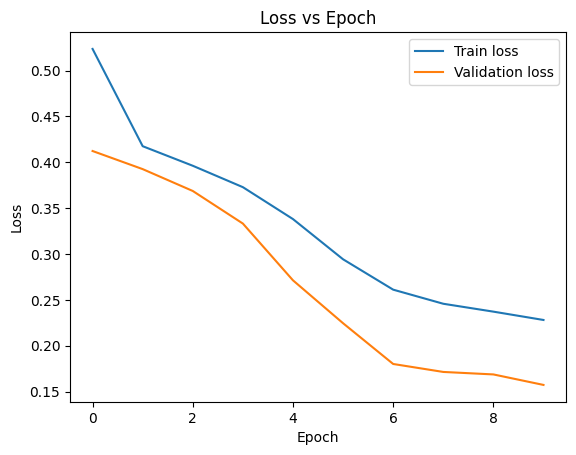

In [12]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list, label = "Train loss")
plt.plot(validation_loss_list, label = "Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

#Inference
예측 함수를 만들어 테스트하면 다음과 같습니다.



In [11]:
def predict(model, input_sequence, max_length=15, SOS_token=2, EOS_token=3):
    model.eval()

    y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)

    num_tokens = len(input_sequence[0])

    for _ in range(max_length):
        # Get source mask
        tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)

        pred = model(input_sequence, y_input, tgt_mask)

        next_item = pred.topk(1)[1].view(-1)[-1].item() # num with highest probability
        next_item = torch.tensor([[next_item]], device=device)

        # Concatenate previous input with predicted best word
        y_input = torch.cat((y_input, next_item), dim=1)

        # Stop if model predicts end of sentence
        if next_item.view(-1).item() == EOS_token:
            break

    return y_input.view(-1).tolist()


# Here we test some examples to observe how the model predicts
examples = [
    torch.tensor([[2, 0, 0, 0, 0, 0, 0, 0, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 1, 1, 1, 1, 1, 1, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 3]], dtype=torch.long, device=device)
]

for idx, example in enumerate(examples):
    result = predict(model, example)
    print(f"Example {idx}")
    print(f"Input: {example.view(-1).tolist()[1:-1]}")
    print(f"Continuation: {result[1:-1]}")
    print()


Example 0
Input: [0, 0, 0, 0, 0, 0, 0, 0]
Continuation: [0, 0, 0, 0, 0, 0, 0, 0, 0]

Example 1
Input: [1, 1, 1, 1, 1, 1, 1, 1]
Continuation: [1, 1, 1, 1, 1, 1, 1, 1]

Example 2
Input: [1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [1, 0, 1, 0, 1, 0, 1, 0]

Example 3
Input: [0, 1, 0, 1, 0, 1, 0, 1]
Continuation: [1, 0, 1, 0, 1, 0, 1, 0]

Example 4
Input: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1, 0]

Example 5
Input: [0, 1]
Continuation: [1, 0, 1, 0, 1, 0, 1, 0]



위와 같은 결과를 얻을 수 있습니다.